# I.Setup

## I.i Setup libraries

In [18]:
import os
import boto3

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import *
from pyspark.sql.functions import udf, broadcast
from pyspark.mllib.clustering import KMeans

import sagemaker
from sagemaker import get_execution_role
import sagemaker_pyspark

from PIL import Image, ImageOps, ImageFilter
import cv2 as cv


from pyspark.sql.functions import col, pandas_udf, PandasUDFType

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# get region
region = boto3.session.Session().region_name
# get bucket: hang's project 8 of openclassrooms
bucket_name = 'hangp8'
img_sample_dir = 's3://{}/train_sample1/'.format(bucket_name)
img_sample_output = 's3a://{}/output_sample/'.format(bucket_name)

## I.ii Setup of SparkSession 
(ref: https://sagemaker-examples.readthedocs.io/en/latest/sagemaker-spark/pyspark_mnist/pyspark_mnist_kmeans.html#Setup)

In [4]:
role = get_execution_role()

# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(jars)

# Sets the Spark master URL to connect to, run locally with all cores available: 'local[*]'
spark = (
    SparkSession.builder.config("spark.driver.extraClassPath", classpath)
    .master("local[*]")
    .getOrCreate()
)

spark

# II. Load image data
Access your files in S3 without copying files into your instance storage<br>
(ref:https://sagemaker-examples.readthedocs.io/en/latest/ingest_data/013_Ingest_image_data_v1.html?highlight=fs.ls#Method-1:-Streaming-data-from-S3-to-the-SageMaker-instance-memory)

In [5]:
# save img path and labels
def get_path_label_list(prefix='train_sample1/', bucket_name=bucket_name):
    s3 = boto3.resource('s3', region_name=region)
    bucket=bucket_name
    my_bucket = s3.Bucket(bucket)
    path_label_list = []
    for (bucket_name, key) in map(lambda x: (x.bucket_name, x.key), my_bucket.objects.filter(Prefix=prefix)):
        # save img path
        img_location = "s3://{}/{}".format(bucket_name, key)
        # save img label
        img_label = img_location.split('/')[-2]
        path_label_list.append((img_location, img_label))
    # remove the root folder
    return path_label_list[1:]

In [35]:
# check result of function
path_label_list = get_path_label_list()
print('Show 1 line of path: {}\nThere are {} images in train_sample.'.format(path_label_list[0], len(path_label_list)))

Show 1 line of path: ('s3://hangp8/train_sample/Apple Pink Lady/0_100.jpg', 'Apple Pink Lady')
There are 1243 images in train_sample.


In [6]:
# create spark dataframe
def create_df(prefix='train_sample1', bucket=bucket_name):
    data = get_path_label_list(prefix, bucket)
    columns = ['path', 'label']
    df_data = spark.createDataFrame(data).toDF(*columns)
    return df_data

In [7]:
# create a initial pyspark dataframe
df_data = create_df()
df_data.show(10, truncate=False)

+------------------------------------------------------+------------------+
|path                                                  |label             |
+------------------------------------------------------+------------------+
|s3://hangp8/train_sample1/Apple Golden Small/0_100.jpg|Apple Golden Small|
|s3://hangp8/train_sample1/Apple Golden Small/1_100.jpg|Apple Golden Small|
|s3://hangp8/train_sample1/Apple Golden Small/2_100.jpg|Apple Golden Small|
|s3://hangp8/train_sample1/Apple Golden Small/3_100.jpg|Apple Golden Small|
|s3://hangp8/train_sample1/Apple Golden Small/4_100.jpg|Apple Golden Small|
|s3://hangp8/train_sample1/Apple Golden Small/5_100.jpg|Apple Golden Small|
|s3://hangp8/train_sample1/Apple Golden Small/6_100.jpg|Apple Golden Small|
+------------------------------------------------------+------------------+



In [8]:
# print shema of Dataframe
df_data.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)



In [9]:
def preprocess(path_img):
    
    '''for each image: create preprocessed image array and orb descriptors'''
    
    my_bucket = bucket_name
    # get in-bucket path
    key = os.path.relpath(path_img, 's3://'+bucket_name+'/')
    
    image_object = boto3.resource("s3", region_name=region).Bucket(my_bucket).Object(key)
    img = Image.open(image_object.get()["Body"])
    
    # preprocess
    # remove 1% extreme lightest and darkest pixels then maximize image contrast
    tmp1 = ImageOps.autocontrast(img, cutoff=1)
    # equalize image histogram to creat a uniform distribution of grayscale
    tmp2 = ImageOps.equalize(tmp1)
    img_out = tmp2
    img_prep = np.array(img_out).flatten().tolist()
    
    # descriptors
    # set max feature to retain = 50
    orb = cv.ORB_create(nfeatures=50)
    _, des = orb.detectAndCompute(np.array(img_out),None)
    img_des = ([] if des is None else des.flatten().tolist())
    
    return (img_prep, img_des)

In [10]:
schema = StructType([
    StructField("img_prep", ArrayType(IntegerType()), False),
    StructField("img_orb_des", ArrayType(IntegerType()), False)])

preprocess_udf = udf(preprocess, schema)

df_data = df_data.withColumn("Output", preprocess_udf('path'))

In [11]:
df_data.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- Output: struct (nullable = true)
 |    |-- img_prep: array (nullable = false)
 |    |    |-- element: integer (containsNull = true)
 |    |-- img_orb_des: array (nullable = false)
 |    |    |-- element: integer (containsNull = true)



In [12]:
df_data.select('path', 'label', 'Output.*').show()

+--------------------+------------------+--------------------+--------------------+
|                path|             label|            img_prep|         img_orb_des|
+--------------------+------------------+--------------------+--------------------+
|s3://hangp8/train...|Apple Golden Small|[255, 255, 255, 2...|[191, 253, 248, 2...|
|s3://hangp8/train...|Apple Golden Small|[255, 255, 255, 2...|[206, 176, 184, 2...|
|s3://hangp8/train...|Apple Golden Small|[255, 255, 255, 2...|[190, 220, 126, 2...|
|s3://hangp8/train...|Apple Golden Small|[255, 255, 255, 2...|[207, 188, 255, 2...|
|s3://hangp8/train...|Apple Golden Small|[255, 255, 255, 2...|[253, 151, 125, 2...|
|s3://hangp8/train...|Apple Golden Small|[255, 255, 243, 2...|[139, 29, 255, 24...|
|s3://hangp8/train...|Apple Golden Small|[255, 255, 255, 2...|[190, 252, 110, 1...|
+--------------------+------------------+--------------------+--------------------+



### KMEANS ORB

In [15]:
# convert flatten descriptors to orb ndarray descriptors (n, 32)
rdd_data = df_data.rdd.map(lambda x: Row(path = x.path,\
                                         label = x.label,\
                                         img_prep = np.array(x['Output']['img_prep']).reshape(100, 100, 3),\
                                         img_orb_des = np.array(x['Output']['img_orb_des']).reshape(-1, 32)
                                        )
                          )
# check orb descriptors of 1st image
rdd_data.first()

Row(img_orb_des=array([[191, 253, 248, 250, 159, 245, 223, 222,  83, 127, 180,  31,  42,
        253,  95, 173, 221, 219, 149, 147, 190, 110, 250, 179, 251, 221,
        157, 127, 255,  93, 222, 223],
       [217, 151, 125, 229,  36, 118,  95, 187,  49, 106, 127, 118, 223,
         63, 154, 243, 119, 213, 181, 238, 249, 244, 121, 143, 230, 251,
        227, 132,  47, 225, 200, 113],
       [190, 220, 126, 250, 207, 247, 159, 254, 155,  95, 221,  31, 108,
        255,  62, 205, 255, 251, 183, 135, 252, 199,  58, 255, 251, 255,
        223, 219, 183,  95, 173, 223],
       [207, 188, 255, 214, 183, 255, 189, 179, 187, 255,  23,  52, 252,
        255, 222, 175, 167, 119, 253,  19, 245, 221, 187, 230, 107,  95,
        127, 195, 142, 228, 205, 119],
       [142, 189, 191, 254, 175, 246, 191, 214, 187,  95, 215, 183, 124,
        255, 191, 175, 247, 127, 181, 147, 177, 205, 186, 235, 123, 127,
        254, 131, 135, 245, 167, 123],
       [138, 156, 255, 254, 247, 246, 255, 246, 153,  79, 1

In [17]:
all_desp = rdd_data.flatMap(lambda row: Row(row['path'], row['label'], row['img_prep'], i) for i in row['img_orb_des']])
all_desp.first()

('s3://hangp8/train_sample1/Apple Golden Small/0_100.jpg',
 'Apple Golden Small',
 array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [25

In [43]:
all_desp.map(lambda row: row[3]).first()

array([191, 253, 248, 250, 159, 245, 223, 222,  83, 127, 180,  31,  42,
       253,  95, 173, 221, 219, 149, 147, 190, 110, 250, 179, 251, 221,
       157, 127, 255,  93, 222, 223])

In [44]:
from pyspark.mllib.clustering import KMeans
# k is n_cluster, suppose 10*categories
k = 10
def create_model(rdd, k):
    # can't select column by name, only by position
    rdd_desp = rdd.map(lambda row: row[3])
    model = KMeans.train(rdd_desp, k, maxIterations=10, initializationMode="random")
    return model

In [45]:
model_kmeans = create_model(all_desp, k)
model_kmeans.predict(all_desp.take(1)[0][3])

7

In [49]:
rdd_data.map(lambda row: row[0]).first()

array([[191, 253, 248, 250, 159, 245, 223, 222,  83, 127, 180,  31,  42,
        253,  95, 173, 221, 219, 149, 147, 190, 110, 250, 179, 251, 221,
        157, 127, 255,  93, 222, 223],
       [217, 151, 125, 229,  36, 118,  95, 187,  49, 106, 127, 118, 223,
         63, 154, 243, 119, 213, 181, 238, 249, 244, 121, 143, 230, 251,
        227, 132,  47, 225, 200, 113],
       [190, 220, 126, 250, 207, 247, 159, 254, 155,  95, 221,  31, 108,
        255,  62, 205, 255, 251, 183, 135, 252, 199,  58, 255, 251, 255,
        223, 219, 183,  95, 173, 223],
       [207, 188, 255, 214, 183, 255, 189, 179, 187, 255,  23,  52, 252,
        255, 222, 175, 167, 119, 253,  19, 245, 221, 187, 230, 107,  95,
        127, 195, 142, 228, 205, 119],
       [142, 189, 191, 254, 175, 246, 191, 214, 187,  95, 215, 183, 124,
        255, 191, 175, 247, 127, 181, 147, 177, 205, 186, 235, 123, 127,
        254, 131, 135, 245, 167, 123],
       [138, 156, 255, 254, 247, 246, 255, 246, 153,  79, 124,  50, 252,
  

In [153]:
desp =  all_desp.map(lambda x: x['desp_orb'])

In [154]:
from pyspark.mllib.clustering import KMeans
# k is n_cluster, suppose 10*categories
k = 10
model = KMeans.train(desp, k, maxIterations=10, initializationMode="random")

In [159]:
def bovw(row, model, k):
    label = row['label']
    path= row['path']
    des = row['desp_orb']
    n_des = len(des)
    bovw = np.zeros(k)
    for des_ in des:
        cluster = model.predict(des_)
        #normalize freq
        bovw[cluster] += 1/n_des
    return Row(path=path, label=label, bovw=bovw.tolist())

In [160]:
bovw_rdd = all_desp.map(lambda x: bovw(x, model, k))

In [158]:
# clustering for each image
bovw_rdd.first()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 88.0 failed 1 times, most recent failure: Lost task 0.0 in stage 88.0 (TID 129, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 390, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/pyspark/rdd.py", line 1354, in takeUpToNumLeft
    yield next(iterator)
  File "/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-157-bb4e7dda086c>", line 1, in <lambda>
  File "<ipython-input-156-01694bd8520e>", line 8, in bovw
  File "/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/mllib/clustering.py", line 260, in predict
    x = _convert_to_vector(x)
  File "/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/mllib/linalg/__init__.py", line 83, in _convert_to_vector
    raise TypeError("Cannot convert type %s into Vector" % type(l))
TypeError: Cannot convert type <class 'numpy.int64'> into Vector

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:588)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:571)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:153)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor98.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 390, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/pyspark/rdd.py", line 1354, in takeUpToNumLeft
    yield next(iterator)
  File "/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-157-bb4e7dda086c>", line 1, in <lambda>
  File "<ipython-input-156-01694bd8520e>", line 8, in bovw
  File "/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/mllib/clustering.py", line 260, in predict
    x = _convert_to_vector(x)
  File "/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/mllib/linalg/__init__.py", line 83, in _convert_to_vector
    raise TypeError("Cannot convert type %s into Vector" % type(l))
TypeError: Cannot convert type <class 'numpy.int64'> into Vector

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:588)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:571)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:153)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [133]:
df_data_rdd = df_data.select('path', 'label').rdd

In [136]:
df_final_rdd = df_data_rdd.union(bovw_rdd)
df_final_rdd.collect()

[Row(path='s3://hangp8/train_sample1/Apple Golden Small/0_100.jpg', label='Apple Golden Small'),
 Row(path='s3://hangp8/train_sample1/Apple Golden Small/1_100.jpg', label='Apple Golden Small'),
 Row(path='s3://hangp8/train_sample1/Apple Golden Small/2_100.jpg', label='Apple Golden Small'),
 Row(path='s3://hangp8/train_sample1/Apple Golden Small/3_100.jpg', label='Apple Golden Small'),
 Row(path='s3://hangp8/train_sample1/Apple Golden Small/4_100.jpg', label='Apple Golden Small'),
 Row(path='s3://hangp8/train_sample1/Apple Golden Small/5_100.jpg', label='Apple Golden Small'),
 Row(path='s3://hangp8/train_sample1/Apple Golden Small/6_100.jpg', label='Apple Golden Small'),
 [0.0,
  0.0,
  0.058823529411764705,
  0.058823529411764705,
  0.058823529411764705,
  0.11764705882352941,
  0.0,
  0.29411764705882354,
  0.23529411764705882,
  0.1764705882352941],
 [0.1, 0.0, 0.1, 0.0, 0.05, 0.1, 0.0, 0.2, 0.25, 0.2],
 [0.047619047619047616,
  0.047619047619047616,
  0.09523809523809523,
  0.0,
  0

In [135]:
df_final_rdd.first()

Row(path='s3://hangp8/train_sample1/Apple Golden Small/0_100.jpg', label='Apple Golden Small')

In [ ]:
def ORB(img):
    # read image in pyspark dataframe, which are saved as flatten list
    arr = np.array(img).reshape(100, 100, 3)
    
    arr = preprocess_input(arr)
    arr = arr.flatten().tolist()
    feature = model.predict(arr.reshape(-1, 3, 100, 100))
    feature = feature.flatten().tolist()
    return feature

img_pred_UDF = udf(lambda img: img_pred(img))
df_data.withColumn('NameCol', img_pred_UDF('Output.img_prep')).show(1)

In [39]:
import pickle

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils


def unpack(model, training_config, weights):
    restored_model = deserialize(model)
    if training_config is not None:
        restored_model.compile(
            **saving_utils.compile_args_from_training_config(
                training_config
            )
        )
    restored_model.set_weights(weights)
    return restored_model

# Hotfix function
def make_keras_picklable():

    def __reduce__(self):
        model_metadata = saving_utils.model_metadata(self)
        training_config = model_metadata.get("training_config", None)
        model = serialize(self)
        weights = self.get_weights()
        return (unpack, (model, training_config, weights))

    cls = Model
    cls.__reduce__ = __reduce__

# Run the function
make_keras_picklable()

In [40]:
import keras
from keras.models import Model
from keras.layers import Flatten
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

# add ResNet50 pre-trained by ImageNet and remove fully-connected layers
model = VGG16(weights="imagenet", include_top=False, input_shape=(3, 100, 100))

In [41]:
#model_new = sc.broadcast(model)
def img_pred(img):
    # read image in pyspark dataframe, which are saved as flatten list
    arr = np.array(img).reshape(100, 100, 3)
    
    arr = preprocess_input(arr)
    arr = arr.flatten().tolist()
    feature = model.predict(arr.reshape(-1, 3, 100, 100))
    feature = feature.flatten().tolist()
    return feature

In [29]:
img_pred_UDF = udf(lambda img: img_pred(img))
df_data.withColumn('NameCol', img_pred_UDF('Output.img_prep')).show(1)

+--------------------+------------------+--------------------+--------------------+
|                path|             label|              Output|             NameCol|
+--------------------+------------------+--------------------+--------------------+
|s3://hangp8/train...|Apple Golden Small|[[255, 255, 255, ...|[151.061004638671...|
+--------------------+------------------+--------------------+--------------------+
only showing top 1 row



In [32]:
from keras.models import Sequential

class PickableSequential(Sequential):
    def __getstate__(self):
        state = super().__getstate__()
        state.pop("_trackable_saver")
        state.pop("_compiled_trainable_state")
        return state

model_pickable = PickableSequential(model)

In [42]:
img_pred_UDF = udf(lambda img: img_pred(img))
df_data.withColumn('NameCol', img_pred_UDF('Output.img_prep')).show(1)

Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/pyspark/serializers.py", line 587, in dumps
    return cloudpickle.dumps(obj, 2)
  File "/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/pyspark/cloudpickle.py", line 863, in dumps
    cp.dump(obj)
  File "/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/pyspark/cloudpickle.py", line 260, in dump
    return Pickler.dump(self, obj)
  File "/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/pickle.py", line 409, in dump
    self.save(obj)
  File "/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/pickle.py", line 476, in save
    f(self, obj) # Call unbound method with explicit self
  File "/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/pickle.py", line 736, in save_tuple
    save(element)
  File "/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/pickle.py", lin

PicklingError: Could not serialize object: TypeError: can't pickle weakref objects

In [184]:
sc = spark.sparkContext
bc_model_weights = sc.broadcast(model.get_weights())

def model_fn():
  """
  Returns a vgg16 model with top layer removed and broadcasted pretrained weights.
  """
  model = VGG16(weights=None, include_top=False, input_shape=(100, 100, 3))
  model.set_weights(bc_model_weights.value)
  return model

In [279]:
from keras.models import load_model
import boto3

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
client = boto3.client('s3')
client.upload_file(Filename='my_model.h5',
                  Bucket=bucket_name,
                  Key='my_model.h5')

In [281]:
client.download_file(bucket_name,
                     'my_model.h5',
                     'my_model.h5')
# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

In [266]:
def toarray(img_prep):
    arr = np.array(img_prep).reshape(100, 100, 3)
    arr = preprocess_input(arr)
    return arr

def featurize_series(model, content_series):
    """Feturize a pd.Series of raw images using the input model.
    return: a pd.Series of image features"""
  
    imgs = np.stack(content_series.map(toarray))
    preds = model.predict(imgs)
    # the output would be 3*3*512
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)


In [20]:
!pip install pyspark==3.0.0

     |████████████████████████████████| 204.7 MB 17 kB/s s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044182 sha256=733a71ae07657fcb6e10148129091eb4cfacaa2f65c4a31494e6afdf7e1da5ea
  Stored in directory: /home/ec2-user/.cache/pip/wheels/4e/c5/36/aef1bb711963a619063119cc032176106827a129c0be20e301
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.1.2
    Uninstalling pyspark-3.1.2:
      Successfully uninstalled pyspark-3.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker-pyspark 1.4.2 requires pyspark==2.4.0, but you have pyspark 3.0.0 which is incompatible.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_latest_p37/bin/python -m pip install --upgrade pip' command.


In [24]:
@pandas_udf('array<float>', PandasUDFType.SCALARITER)

def featurize_udf(content_series_iter):
    '''This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
    content_series_iter: This argument is an iterator over batches of data, 
    where each batch is a pandas Series of image data.'''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    #feature = pd.Series()
    #for content_series in content_series_iter:
        #feature.append(featurize_series(model, content_series))
    return featurize_series(model, content_series_iter)
    

AttributeError: type object 'PandasUDFType' has no attribute 'SCALARITER'

In [268]:
# Pandas UDFs on large records (e.g., very large images) can run into Out Of Memory (OOM) errors.
# If you hit such errors in the cell below, try reducing the Arrow batch size via `maxRecordsPerBatch`.
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [269]:
# We can now run featurization on our entire Spark DataFrame.
# NOTE: This can take a long time (about 10 minutes) since it applies a large model to the full dataset.
features_df = df_tt10.select(col("img_prep"), featurize_udf("img_prep").alias("cnn_features"))
#features_df.write.mode("overwrite").parquet("dbfs:/ml/tmp/flower_photos_features")

In [270]:
features_df.printSchema()

root
 |-- img_prep: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- cnn_features: array (nullable = true)
 |    |-- element: float (containsNull = true)



In [271]:
features_df.show()

Py4JJavaError: An error occurred while calling o2496.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 90.0 failed 1 times, most recent failure: Lost task 0.0 in stage 90.0 (TID 105, localhost, executor driver): java.lang.IllegalArgumentException
	at java.nio.ByteBuffer.allocate(ByteBuffer.java:334)
	at org.apache.arrow.vector.ipc.message.MessageSerializer.readMessage(MessageSerializer.java:543)
	at org.apache.arrow.vector.ipc.message.MessageChannelReader.readNext(MessageChannelReader.java:58)
	at org.apache.arrow.vector.ipc.ArrowStreamReader.readSchema(ArrowStreamReader.java:132)
	at org.apache.arrow.vector.ipc.ArrowReader.initialize(ArrowReader.java:181)
	at org.apache.arrow.vector.ipc.ArrowReader.ensureInitialized(ArrowReader.java:172)
	at org.apache.arrow.vector.ipc.ArrowReader.getVectorSchemaRoot(ArrowReader.java:65)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:162)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:122)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec$$anon$2.<init>(ArrowEvalPythonExec.scala:98)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec.evaluate(ArrowEvalPythonExec.scala:96)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:127)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:89)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:365)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3384)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2545)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2545)
	at org.apache.spark.sql.Dataset$$anonfun$53.apply(Dataset.scala:3365)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3364)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2545)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2759)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:255)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:292)
	at sun.reflect.GeneratedMethodAccessor99.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.IllegalArgumentException
	at java.nio.ByteBuffer.allocate(ByteBuffer.java:334)
	at org.apache.arrow.vector.ipc.message.MessageSerializer.readMessage(MessageSerializer.java:543)
	at org.apache.arrow.vector.ipc.message.MessageChannelReader.readNext(MessageChannelReader.java:58)
	at org.apache.arrow.vector.ipc.ArrowStreamReader.readSchema(ArrowStreamReader.java:132)
	at org.apache.arrow.vector.ipc.ArrowReader.initialize(ArrowReader.java:181)
	at org.apache.arrow.vector.ipc.ArrowReader.ensureInitialized(ArrowReader.java:172)
	at org.apache.arrow.vector.ipc.ArrowReader.getVectorSchemaRoot(ArrowReader.java:65)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:162)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:122)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec$$anon$2.<init>(ArrowEvalPythonExec.scala:98)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec.evaluate(ArrowEvalPythonExec.scala:96)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:127)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:89)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [144]:
schema = StructType([StructField("sum", ArrayType(IntegerType()), False)])
df_test = df_tt10.rdd.map(lambda x: x)
df_test.toDF(schema).show()

Py4JJavaError: An error occurred while calling o1200.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 44.0 failed 1 times, most recent failure: Lost task 0.0 in stage 44.0 (TID 40, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 390, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyspark/sql/session.py", line 730, in prepare
    verify_func(obj)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyspark/sql/types.py", line 1389, in verify
    verify_value(obj)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyspark/sql/types.py", line 1377, in verify_struct
    % (obj, type(obj))))
TypeError: StructType can not accept object 4596736 in type <class 'int'>

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:588)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:571)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$11$$anon$1.hasNext(WholeStageCodegenExec.scala:619)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:365)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3384)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2545)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2545)
	at org.apache.spark.sql.Dataset$$anonfun$53.apply(Dataset.scala:3365)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3364)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2545)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2759)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:255)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:292)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 390, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyspark/sql/session.py", line 730, in prepare
    verify_func(obj)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyspark/sql/types.py", line 1389, in verify
    verify_value(obj)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyspark/sql/types.py", line 1377, in verify_struct
    % (obj, type(obj))))
TypeError: StructType can not accept object 4596736 in type <class 'int'>

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:588)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:571)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$11$$anon$1.hasNext(WholeStageCodegenExec.scala:619)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [11]:
# content of img_prep: 3*100pixel*100pixel
len(df_data.select('Output.img_prep').take(1)[0][0])

30000

In [14]:
# content of img_orb_des: descriptors detected: 32(orb descriptor lenth) * n(number of descriptors)
len(df_data.select('Output.img_orb_des').take(2)[0][0]), len(df_data.select('Output.img_orb_des').take(2)[1][0])

(128, 384)

In [15]:
# img_prep : list of 30000 elements
# img_orb_des : list of 32*n elements, where n = 0,1,2,3...
df_data.select('path', 'label', 'Output.*').show(5)

+--------------------+---------------+--------------------+--------------------+
|                path|          label|            img_prep|         img_orb_des|
+--------------------+---------------+--------------------+--------------------+
|s3://hangp8/train...|Apple Pink Lady|[255, 255, 255, 2...|[252, 252, 61, 12...|
|s3://hangp8/train...|Apple Pink Lady|[255, 255, 255, 2...|[223, 22, 255, 24...|
|s3://hangp8/train...|Apple Pink Lady|[255, 255, 255, 2...|[237, 253, 189, 1...|
|s3://hangp8/train...|Apple Pink Lady|[255, 255, 255, 2...|[223, 22, 255, 25...|
|s3://hangp8/train...|Apple Pink Lady|[255, 255, 255, 2...|[191, 180, 253, 2...|
+--------------------+---------------+--------------------+--------------------+
only showing top 5 rows



In [44]:
pip install sparkdl

     |████████████████████████████████| 99 kB 10.0 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [48]:
import pyspark
pyspark.__version__

'2.4.0'

In [ ]:
!pip install pyspark -U

In [46]:
pip install tensorframes

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install kafka

     |████████████████████████████████| 207 kB 56.6 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install tensorflowonspark

     |████████████████████████████████| 45 kB 4.5 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install keras -U

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install tensorflow

     |████████████████████████████████| 454.3 MB 12 kB/s s eta 0:00:01     |███████████████████████████████▍| 446.0 MB 60.5 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 19.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 49.4 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 38.7 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 582 kB/s  eta 0:00:01
     |████████████████████████████████| 6.0 MB 73.2 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 81.7 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 1.8 MB/s  eta 0:00:01
     |████████████████████████████████| 781 kB 60.0 MB/s eta 0:00:01
     |████████████████████████████████| 152 kB 88.5 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 1.2 MB/s  eta 0:00:01
     |████████████████████████████████| 4.9 MB 76.2 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 74.9 MB/s eta 0:00:01
     |████████████████████████████

In [2]:
pip install jieba

     |████████████████████████████████| 19.2 MB 15.0 MB/s eta 0:00:01
  Created wheel for jieba: filename=jieba-0.42.1-py3-none-any.whl size=19314477 sha256=cd9b219f797d194fbbb9f6be7895f2043ef05b579b62ad0c793660e7d68b634c
  Stored in directory: /home/ec2-user/.cache/pip/wheels/17/a7/8b/a7e03881534e78558920ac68aaeca05180c0e2c3d11c4fce3b
Successfully built jieba
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [50]:
#import sparkdl
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from sparkdl import DeepImageFeaturizer 
# extracting feature from images
featurizer = DeepImageFeaturizer(inputCol="image",
                                 outputCol="features",
                                 modelName="InceptionV3")

AttributeError: module 'sparkdl' has no attribute 'graph'

In [51]:
from sparkdl import KerasTransformer


AttributeError: module 'sparkdl' has no attribute 'graph'

In [25]:
featurizer.transform(df_data.select('Output.img_prep').take(5))

AttributeError: module 'tensorflow' has no attribute 'Session'

In [16]:
import keras
from keras.models import Model
from keras.layers import Flatten
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

# add ResNet50 pre-trained by ImageNet and remove fully-connected layers
model = VGG16(weights="imagenet", include_top=False, input_shape=(3, 100, 100))

ModuleNotFoundError: No module named 'keras'

In [291]:
img_ = preprocess_input(img) # preprocess image as VGG16 model want (normalize pixel value to (-1,1))
model.predict(img_.reshape(-1, 100, 100, 3)).shape

(1, 3, 3, 512)

In [52]:
feature_cnn = model.predict(img_.reshape(-1, 100, 100, 3))

In [57]:
feature_cnn.flatten().tolist()[:100]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 10.22053050994873,
 0.0,
 0.0,
 1.8791835308074951,
 0.0,
 0.0,
 18.117979049682617,
 0.0,
 0.0,
 0.0,
 4.977135181427002,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.11366993188858032,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.24408940970897675,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 9.639677047729492,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 19.597660064697266,
 0.0,
 0.0,
 0.0,
 3.611595630645752,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 14.506049156188965,
 34.555381774902344,
 0.0,
 0.0,
 0.0,
 0.0]

In [45]:
type(img_)

numpy.ndarray

In [31]:
df_data.select('Output.img_prep').count()

1243

In [32]:
model.predict(df_data.select('Output.img_prep'))

ValueError: Failed to find data adapter that can handle input: <class 'pyspark.sql.dataframe.DataFrame'>, <class 'NoneType'>

# Export data to S3

In [36]:
df_data.write.parquet('s3a://{}/output_sample/'.format(bucket_name), mode="overwrite")

In [38]:
df_check = spark.read.parquet('s3a://hangp8/output_sample/')

In [39]:
df_check.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- Output: struct (nullable = true)
 |    |-- img_prep: array (nullable = true)
 |    |    |-- element: integer (containsNull = true)
 |    |-- img_orb_des: array (nullable = true)
 |    |    |-- element: integer (containsNull = true)



In [40]:
df_check.select('path', 'label', 'Output.*').show(5)

+--------------------+---------------+--------------------+--------------------+
|                path|          label|            img_prep|         img_orb_des|
+--------------------+---------------+--------------------+--------------------+
|s3://hangp8/train...|Apple Pink Lady|[255, 255, 255, 2...|[252, 252, 61, 12...|
|s3://hangp8/train...|Apple Pink Lady|[255, 255, 255, 2...|[223, 22, 255, 24...|
|s3://hangp8/train...|Apple Pink Lady|[255, 255, 255, 2...|[237, 253, 189, 1...|
|s3://hangp8/train...|Apple Pink Lady|[255, 255, 255, 2...|[223, 22, 255, 25...|
|s3://hangp8/train...|Apple Pink Lady|[255, 255, 255, 2...|[191, 180, 253, 2...|
+--------------------+---------------+--------------------+--------------------+
only showing top 5 rows



# Brouillons

## Import of dataframe

In [2]:
import pandas as pd

input_data = "s3://hangtestbucket/test.csv".format(region)
df = pd.read_csv(input_data, nrows=10)
df.head(n=10)

,Unnamed: 0,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,client_installments_AMT_PAYMENT_min_sum,DAYS_BIRTH,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,bureau_DAYS_CREDIT_ENDDATE_max,...,previous_PRODUCT_COMBINATION_Cash Street: high_sum,client_credit_AMT_DRAWINGS_CURRENT_max_min,NAME_FAMILY_STATUS_Civil marriage,client_cash_NAME_CONTRACT_STATUS_Returned to the store_mean_max,client_installments_NUM_INSTALMENT_NUMBER_min_max,previous_CHANNEL_TYPE_Stone_mean,previous_WEEKDAY_APPR_PROCESS_START_THURSDAY_sum,client_bureau_balance_STATUS_C_count_min,client_credit_CNT_DRAWINGS_POS_CURRENT_sum_max,OCCUPATION_TYPE_High skill tech staff
0,0,0.752614,0.789654,0.159520,27746.775,-19241,568800.0,20560.5,-2329,1778.0,...,0.0,NaN,0,0.0,2.0,0.00,0.0,0.0,NaN,0
1,1,0.564990,0.291656,0.432962,43318.800,-18064,222768.0,17370.0,-4469,1324.0,...,0.0,NaN,0,0.0,1.0,0.00,1.0,0.0,NaN,0
2,2,NaN,0.699787,0.610991,66875.266,-20038,663264.0,69777.0,-4458,-567.0,...,0.0,157500.000,0,0.0,1.0,0.25,1.0,0.0,0.0,0
3,3,0.525734,0.509677,0.612704,172044.310,-13976,1575000.0,49018.5,-1866,30885.0,...,0.0,22823.550,0,0.0,1.0,0.00,4.0,0.0,115.0,0
4,4,0.202145,0.425687,NaN,133169.400,-13040,625500.0,32067.0,-2191,NaN,...,0.0,NaN,0,0.0,1.0,0.00,0.0,NaN,NaN,0
5,5,NaN,0.628904,0.392774,1842460.900,-18604,959688.0,34600.5,-12009,8957.0,...,1.0,87750.000,0,0.0,1.0,0.00,2.0,0.0,8.0,0
6,6,0.760851,0.571084,0.651260,68259.330,-16685,499221.0,22117.5,-2580,5813.0,...,0.0,NaN,0,0.0,1.0,0.00,0.0,0.0,NaN,1
7,7,0.565290,0.613033,0.312365,90619.650,-9516,180000.0,14220.0,-1387,27225.0,...,0.0,NaN,0,0.0,1.0,0.50,0.0,0.0,NaN,0
8,8,0.718507,0.808788,0.522697,451534.880,-12744,364896.0,28957.5,-1013,1363.0,...,0.0,0.000,0,0.0,1.0,0.00,0.0,0.0,0.0,0
9,9,0.210562,0.444848,0.194068,272273.840,-10395,45000.0,5337.0,-2625,30886.0,...,1.0,46897.695,1,0.0,1.0,0.00,7.0,0.0,51.0,0


## Import and export image to S3

In [22]:
from PIL import Image, ImageOps, ImageFilter
import matplotlib.pyplot as plt
import cv2 as cv

In [24]:
from PIL import Image
from io import BytesIO
import numpy as np
def read_image_from_s3(path, region_name=region, bucket='hangtestbucket'):
    """Load image file from s3.

    Parameters
    ----------
    bucket: string
        Bucket name
    path : string
        Path in s3

    Returns
    -------
    np array
        Image array
    """
    s3 = boto3.resource('s3', region_name=region_name)
    bucket = s3.Bucket(bucket)
    object = bucket.Object(path)
    response = object.get()
    file_stream = response['Body']
    im = Image.open(file_stream)
    return np.array(im)

def write_image_to_s3(img_array, path, region_name=region, bucket='hangtestbucket'):
    """Write an image array into S3 bucket

    Parameters
    ----------
    bucket: string
        Bucket name
    path : string
        Path in s3

    Returns
    -------
    None
    """
    s3 = boto3.resource('s3', region_name)
    bucket = s3.Bucket(bucket)
    object = bucket.Object(path)
    file_stream = BytesIO()
    im = Image.fromarray(img_array)
    im.save(file_stream, format='jpeg')
    object.put(Body=file_stream.getvalue())

In [26]:
img.shape

(100, 100, 3)

In [24]:
img[42,42,0]

117

In [31]:
img_preptmpq.shape

(30000,)

In [30]:
#tmp11 = ImageOps.autocontrast(img, cutoff=1)
# equalize image histogram to creat a uniform distribution of grayscale
#tmp22 = ImageOps.equalize(tmp1)

#img_preptmp = np.array(tmp22)
img_preptmpq = img.flatten()

In [32]:
img_p = img_preptmpq.reshape(100, 100, 3)

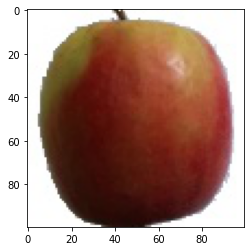

In [25]:
import matplotlib.pyplot as plt
img = read_image_from_s3(path='75_100.jpg')
plt.imshow(img)

In [46]:
write_image_to_s3(img, path='export_test.jpeg')

In [26]:
df = spark.read.format("image").option("dropInvalid", True).load("s3a://hangtestbucket/75_100.jpg")
df.select("image.origin", "image.width", "image.height").show()

+--------------------+-----+------+
|              origin|width|height|
+--------------------+-----+------+
|s3a://hangtestbuc...|  100|   100|
+--------------------+-----+------+

